In [121]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hypertools as hyp
import time, glob, itertools
import geoplot as gplt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib nbagg

In [122]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)

In [123]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


In [124]:
frame['HUC_12']=frame.HUC_12.astype(str)

In [125]:
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [126]:
inHouse=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\inhouse_elemental.csv')

In [127]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(inHouse.longitude, inHouse.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(inHouse, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

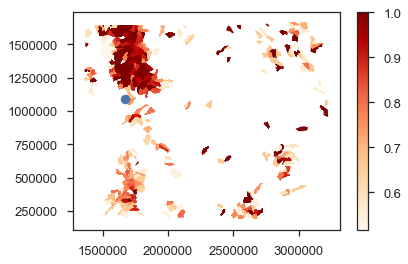

In [152]:
fig, ax = plt.subplots()
CaptainHucstable[(CaptainHucstable['element']=='co_ppm') &
                 (CaptainHucstable['bins_ppm']>10) & (CaptainHucstable['prob']>0.5)].plot(ax=ax, column='prob', cmap='OrRd', legend=True)
projGeoDF.iloc[0:1].plot(ax=ax)


In [139]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [186]:
val_huc[val_huc['HUC_12']==val_huc.HUC_12.unique()[0]]['co_ppm'].values

array([1.])

In [195]:
from scipy import stats

stats.mode(CaptainHucstable[(CaptainHucstable['element']=='co_ppm')& (CaptainHucstable['HUC_12']==val_huc.HUC_12.unique()[0]) &
                CaptainHucstable['prob']>0.9]['bins_ppm'].values)

ModeResult(mode=array([5.2]), count=array([6]))

In [182]:
val_huc[val_huc['HUC_12']==val_huc.HUC_12.unique()[0]]

,AREA,PERIMETER,WY_HU12_,WY_HU12_ID,HUC_8,HUC_10,HUC_12,ACRES,STATES,NCONTRB_A,...,ti_ppm,ti_pct,tm_ppm,u_ppm,v_ppm,w_ppm,y_ppm,yb_ppm,zn_ppm,zr_ppm
76,0.012441,0.634663,255,104,10080014,1008001404,100800140408,26978.198886,"MT,WY",0.0,...,NaN,0.06,0.11,1.72,23.0,1.0,6.6,0.7,23.0,173.0
